In [ ]:
import os

import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np


# Assuming TrainTest is defined elsewhere in your codebase
# from your_module import TrainTest
class TrainTest:
    def __init__(
        self,
        data: pd.DataFrame,
        number_of_observation_per_window: int,
        split_ratio_list: list[float],
    ) -> None:
        self.data: pd.DataFrame = data
        self.number_of_observation_per_window: int = number_of_observation_per_window
        self.split_ratio: list[float] = split_ratio_list

        num_total_observations: int = self.data.shape[
            0
        ]  # Calculate the total number of observations in the DataFrame
        num_observations_cumulative_split: list[float] = (
            num_total_observations * np.cumsum(split_ratio_list)
        )  # np.cumsum([0.7, 0.2, 0.1]) = [0.7, 0.9, 1.0]
        self.cumulative_number_window_observation: list[int] = [
            round(num_observation_cumulative_split)
            for num_observation_cumulative_split in num_observations_cumulative_split
        ]

    def split_update(self, split_ratio_list: list[float]) -> None:
        self.split_ratio: list[float] = split_ratio_list
        num_observations_total: int = self.data.shape[0]
        num_observations_cumulative_split: list[float] = (
            num_observations_total * np.cumsum(split_ratio_list)
        )  # np.cumsum([0.7, 0.2, 0.1]) = [0.7, 0.9, 1.0]
        self.cumulative_number_window_observation = [
            round(i) for i in num_observations_cumulative_split
        ]

    def train(self) -> pd.DataFrame:
        return self.data[
            : self.cumulative_number_window_observation[0]
        ]  # Return the training subset of observations

    def test(self):
        if (
            self.cumulative_number_window_observation[0]
            - self.number_of_observation_per_window
            < 0
        ):
            raise ValueError(
                "The number of observations per window exceeds the number of observations of train data in the dataset."
            )
        return self.data[
            self.cumulative_number_window_observation[0]
            - self.number_of_observation_per_window : self.cumulative_number_window_observation[
                1
            ]
        ]

    def shape(self):
        return self.data.shape


def AV_yFinance(
    start: str,
    end: str,
    split: list[float],
    freq: str = "weekly",
    n_obs: int = 104,
    n_y: int | None = None,
    use_cache: bool = False,
    save_results: bool = False,
) -> tuple[TrainTest, TrainTest]:

    if use_cache:
        X = pd.read_pickle(f"./cache/factor_{freq}.pkl")
        Y = pd.read_pickle(f"./cache/asset_{freq}.pkl")
    else:
        # Define the list of tickers
        tick_list = [
            "AAPL",
            "MSFT",
            "AMZN",
            "C",
            "JPM",
            "BAC",
            "XOM",
            "HAL",
            "MCD",
            "WMT",
            "COST",
            "CAT",
            "LMT",
            "JNJ",
            "PFE",
            "DIS",
            "VZ",
            "T",
            "ED",
            "NEM",
        ]

        if n_y is not None:
            tick_list = tick_list[:n_y]

        # Download asset data using yfinance
        data = yf.download(
            tick_list,
            start=start,
            end=end,
            progress=False,
            group_by="ticker",
            auto_adjust=True,  # Adjusted close prices
            threads=True,  # Enable multi-threading for faster downloads
        )

        if data.empty:
            raise ValueError(
                "No data downloaded. Please check the ticker symbols and date range."
            )

        # Extract Adjusted Close prices
        if len(tick_list) == 1:
            # For single ticker, data['Close'] is a Series, convert to DataFrame
            adj_close = data["Close"].to_frame()
            adj_close.columns = tick_list
        else:
            # For multiple tickers, use xs to extract 'Close' for all tickers
            try:
                adj_close = data.xs("Close", level=1, axis=1)
            except KeyError:
                raise KeyError("Close prices not found in the downloaded data.")

        # Compute daily returns as percentage change
        Y = adj_close.pct_change().dropna()

        # Download factor data from Kenneth French's data library
        dl_freq = "_daily"

        try:
            # 5-Factor Model
            factor_5 = pdr.get_data_famafrench(
                "F-F_Research_Data_5_Factors_2x3" + dl_freq,
                start=start,
                end=end,
            )[0]
            rf_df = factor_5["RF"]
            factor_5 = factor_5.drop(["RF"], axis=1)

            # Momentum Factor
            mom_df = pdr.get_data_famafrench(
                "F-F_Momentum_Factor" + dl_freq,
                start=start,
                end=end,
            )[0]

            # Short-Term Reversal Factor
            st_df = pdr.get_data_famafrench(
                "F-F_ST_Reversal_Factor" + dl_freq,
                start=start,
                end=end,
            )[0]

            # Long-Term Reversal Factor
            lt_df = pdr.get_data_famafrench(
                "F-F_LT_Reversal_Factor" + dl_freq,
                start=start,
                end=end,
            )[0]

            # Concatenate all factors and convert to decimal
            X = pd.concat([factor_5, mom_df, st_df, lt_df], axis=1) / 100
        except Exception as e:
            raise ValueError(f"Failed to download factor data: {e}")

        # Align factor data (X) with asset returns (Y) based on dates

        # Remove timezone from Y.index if present
        if Y.index.tz is not None:
            Y.index = Y.index.tz_convert(None)

        # Ensure X.index is also timezone-naive
        if X.index.tz is not None:
            X.index = X.index.tz_convert(None)

        # Now, perform the alignment
        try:
            X = X.loc[Y.index]
        except KeyError as e:
            missing_dates = Y.index.difference(X.index)
            if not missing_dates.empty:
                print(f"Missing dates in factor data: {missing_dates}")
                # Optionally, you can drop missing dates or handle them differently
                Y = Y.loc[Y.index.intersection(X.index)]
                X = X.loc[X.index.intersection(Y.index)]
            else:
                raise e  # Re-raise if no missing dates found

        # Resample data if frequency is not daily
        freq_lower = freq.lower()
        if freq_lower in ["weekly", "wk", "1wk"]:
            Y = Y.resample("W-FRI").apply(lambda x: (x + 1).prod() - 1)
            X = X.resample("W-FRI").apply(lambda x: (x + 1).prod() - 1)
        elif freq_lower in ["monthly", "1mo"]:
            Y = Y.resample("M").apply(lambda x: (x + 1).prod() - 1)
            X = X.resample("M").apply(lambda x: (x + 1).prod() - 1)
        # Add more resampling frequencies if needed

        # Handle missing values by forward and backward filling using ffill() and bfill()
        Y = Y.ffill().bfill()
        X = X.ffill().bfill()

        # Convert the index to 'YYYY-MM-DD' format
        X.index = X.index.strftime("%Y-%m-%d")
        X.index = pd.DatetimeIndex(X.index)
        Y.index = Y.index.strftime("%Y-%m-%d")
        X.index = pd.DatetimeIndex(Y.index)

        # Optionally save the results to cache
        if save_results:
            os.makedirs("./cache", exist_ok=True)
            X.to_pickle(f"./cache/factor_{freq}.pkl")
            Y.to_pickle(f"./cache/asset_{freq}.pkl")
    print(X.shape, Y.shape)
    # Partition dataset into training and testing sets. Lag the data by one observation
    # Using the provided TrainTest class
    print(X.head(), Y.head())
    print(X.tail(), Y.tail())
    print("above is the original data")
    X_train_test = TrainTest(X[:-1], n_obs, split)
    Y_train_test = TrainTest(Y[1:], n_obs, split)

    return X_train_test, Y_train_test


start_paddling = "1997-04-01"
end_paddling = "2024-10-01"  # Data frequency and start/end dates
daily_frequency = "daily"
xf_train_test, yf_train_test = AV_yFinance(
    start=start_paddling,
    end=end_paddling,
    split=[0.9, 0.1],
    freq=daily_frequency,
    n_obs=104,
    n_y=20,
    use_cache=False,
    save_results=True,
)

C:\Users\zhang\AppData\Local\Temp\ipykernel_37072\3838677905.py:146: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_5 = pdr.get_data_famafrench(
C:\Users\zhang\AppData\Local\Temp\ipykernel_37072\3838677905.py:155: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mom_df = pdr.get_data_famafrench(
C:\Users\zhang\AppData\Local\Temp\ipykernel_37072\3838677905.py:162: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  st_df = pdr.get_data_famafrench(
C:\Users\zhang\AppData\Local\Temp\ipykernel_37072\3838677905.py:169: FutureWarning: The

(6888, 8) (6888, 20)
            Mkt-RF     SMB     HML     RMW     CMA  Mom     ST_Rev  LT_Rev
Date                                                                      
1997-05-16 -0.0113  0.0108  0.0037 -0.0044  0.0047 -0.0036  0.0113  0.0069
1997-05-19  0.0027 -0.0004 -0.0028 -0.0001  0.0006  0.0024  0.0016  0.0000
1997-05-20  0.0091 -0.0055 -0.0021  0.0030 -0.0079 -0.0001 -0.0050 -0.0078
1997-05-21 -0.0013  0.0073 -0.0073 -0.0013 -0.0006 -0.0056  0.0022  0.0010
1997-05-22 -0.0027  0.0064  0.0041 -0.0008  0.0008 -0.0011  0.0029  0.0005 Ticker           CAT         C       LMT         T      AMZN        VZ  \
Date                                                                     
1997-05-16  0.001271 -0.013392 -0.004143  0.002183 -0.117028  0.000000   
1997-05-19 -0.005076  0.009049  0.016644  0.002179 -0.012040  0.000000   
1997-05-20 -0.010204  0.033632  0.013642  0.006522 -0.042685  0.000000   
1997-05-21 -0.002577 -0.030368  0.008075 -0.017279 -0.127392 -0.001815   
1997-05-22

In [8]:
print(
    xf_train_test.train().shape,
    yf_train_test.train().shape,
    xf_train_test.test().shape,
    yf_train_test.test().shape,
)
print(xf_train_test.train().head(), xf_train_test.test().tail())
print(yf_train_test.train().head(), yf_train_test.test().tail())

(6198, 8) (6198, 20) (793, 8) (793, 20)
            Mkt-RF     SMB     HML     RMW     CMA  Mom     ST_Rev  LT_Rev
Date                                                                      
1997-05-16 -0.0113  0.0108  0.0037 -0.0044  0.0047 -0.0036  0.0113  0.0069
1997-05-19  0.0027 -0.0004 -0.0028 -0.0001  0.0006  0.0024  0.0016  0.0000
1997-05-20  0.0091 -0.0055 -0.0021  0.0030 -0.0079 -0.0001 -0.0050 -0.0078
1997-05-21 -0.0013  0.0073 -0.0073 -0.0013 -0.0006 -0.0056  0.0022  0.0010
1997-05-22 -0.0027  0.0064  0.0041 -0.0008  0.0008 -0.0011  0.0029  0.0005             Mkt-RF     SMB     HML     RMW     CMA  Mom     ST_Rev  LT_Rev
Date                                                                      
2024-09-23  0.0021 -0.0083 -0.0008  0.0045 -0.0023 -0.0062 -0.0013 -0.0015
2024-09-24  0.0024 -0.0010 -0.0058 -0.0030  0.0078  0.0003  0.0031 -0.0037
2024-09-25 -0.0029 -0.0093 -0.0070 -0.0004  0.0015  0.0100 -0.0003 -0.0028
2024-09-26  0.0042  0.0023  0.0043 -0.0053  0.0053 -0.0065  

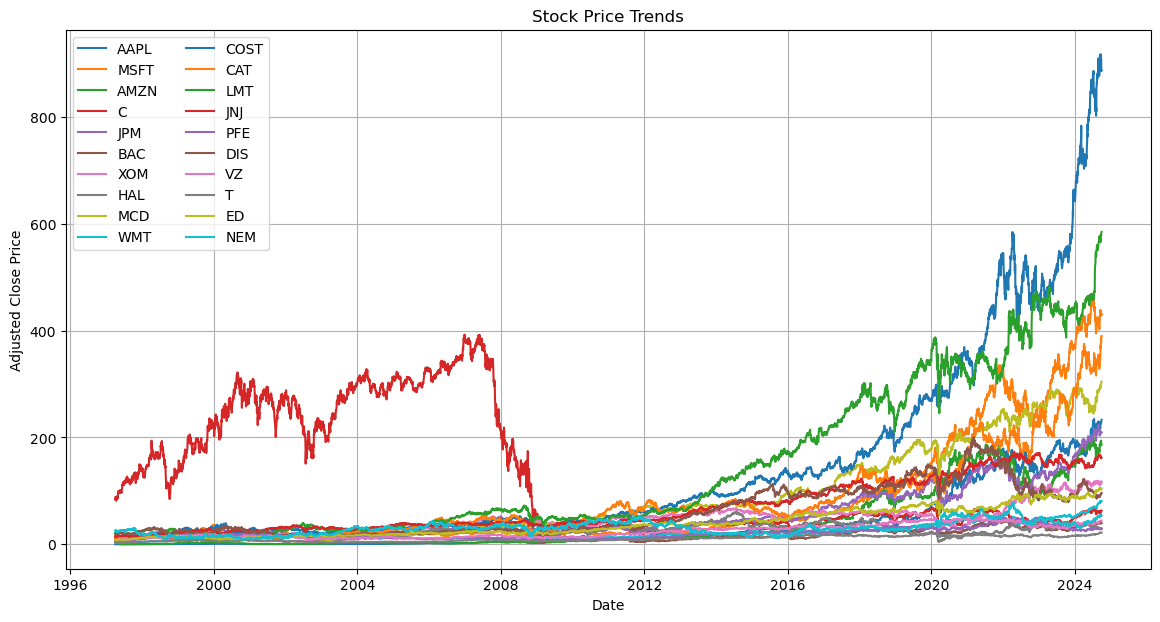

In [3]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

# Define your list of tickers
tick_list = [
    "AAPL",
    "MSFT",
    "AMZN",
    "C",
    "JPM",
    "BAC",
    "XOM",
    "HAL",
    "MCD",
    "WMT",
    "COST",
    "CAT",
    "LMT",
    "JNJ",
    "PFE",
    "DIS",
    "VZ",
    "T",
    "ED",
    "NEM",
]

# Download adjusted close prices
start_date = "1997-04-01"
end_date = "2024-10-01"

data = yf.download(
    tick_list,
    start=start_date,
    end=end_date,
    progress=False,
    group_by="ticker",
    auto_adjust=True,
    threads=True,
)

# Extract adjusted close prices
if len(tick_list) == 1:
    adj_close = data["Close"].to_frame()
    adj_close.columns = tick_list
else:
    adj_close = data.xs("Close", level=1, axis=1)

# Plot the price trends
plt.figure(figsize=(14, 7))

for ticker in tick_list:
    plt.plot(adj_close.index, adj_close[ticker], label=ticker)

plt.title("Stock Price Trends")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(loc="upper left", ncol=2)
plt.grid(True)
plt.show()

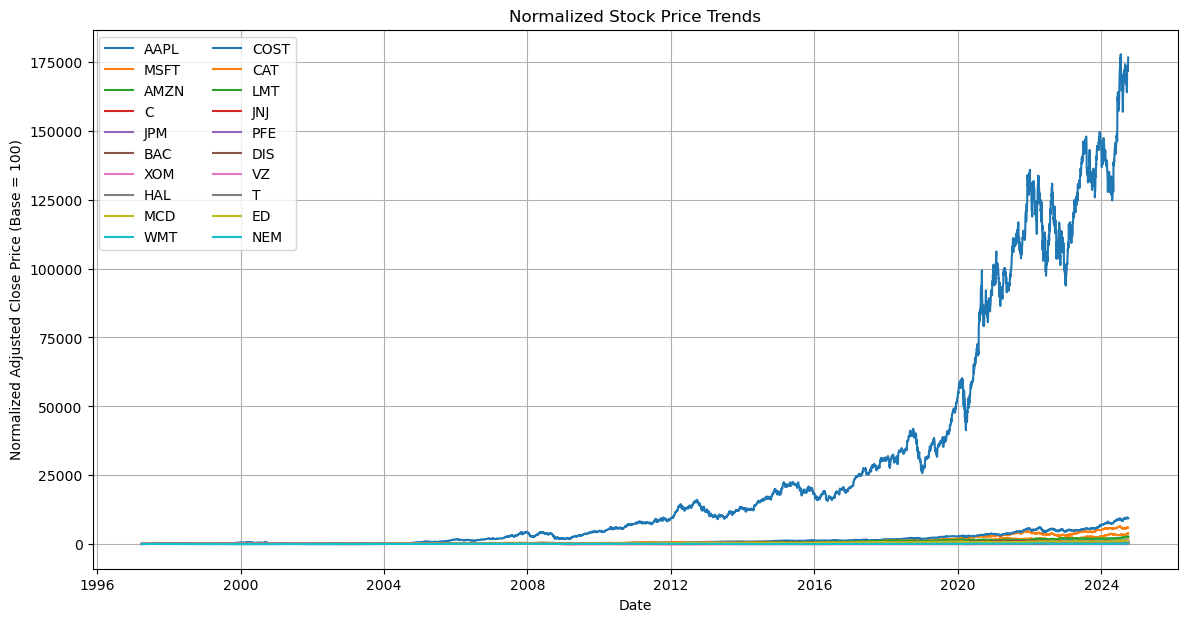

In [4]:
# Normalize the adjusted close prices
normalized_prices = adj_close / adj_close.iloc[0] * 100

# Plot the normalized price trends
plt.figure(figsize=(14, 7))

for ticker in tick_list:
    plt.plot(normalized_prices.index, normalized_prices[ticker], label=ticker)

plt.title("Normalized Stock Price Trends")
plt.xlabel("Date")
plt.ylabel("Normalized Adjusted Close Price (Base = 100)")
plt.legend(loc="upper left", ncol=2)
plt.grid(True)
plt.show()

C:\Users\zhang\AppData\Local\Temp\ipykernel_37072\3456173067.py:149: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_5 = pdr.get_data_famafrench(
C:\Users\zhang\AppData\Local\Temp\ipykernel_37072\3456173067.py:158: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mom_df = pdr.get_data_famafrench(
C:\Users\zhang\AppData\Local\Temp\ipykernel_37072\3456173067.py:165: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  st_df = pdr.get_data_famafrench(
C:\Users\zhang\AppData\Local\Temp\ipykernel_37072\3456173067.py:172: FutureWarning: The

Factor Data Shape: (6888, 8), Asset Data Shape: (6888, 20)
X Train Shape: (6198, 8) 
Y Train Shape: (6198, 20) 
X Test Shape: (793, 8) 
Y Test Shape: (793, 20)

X Train Head:
             Mkt-RF     SMB     HML     RMW     CMA  Mom     ST_Rev  LT_Rev
Date                                                                      
1997-05-16 -0.0113  0.0108  0.0037 -0.0044  0.0047 -0.0036  0.0113  0.0069
1997-05-19  0.0027 -0.0004 -0.0028 -0.0001  0.0006  0.0024  0.0016  0.0000
1997-05-20  0.0091 -0.0055 -0.0021  0.0030 -0.0079 -0.0001 -0.0050 -0.0078
1997-05-21 -0.0013  0.0073 -0.0073 -0.0013 -0.0006 -0.0056  0.0022  0.0010
1997-05-22 -0.0027  0.0064  0.0041 -0.0008  0.0008 -0.0011  0.0029  0.0005

X Test Tail:
             Mkt-RF     SMB     HML     RMW     CMA  Mom     ST_Rev  LT_Rev
Date                                                                      
2024-09-23  0.0021 -0.0083 -0.0008  0.0045 -0.0023 -0.0062 -0.0013 -0.0015
2024-09-24  0.0024 -0.0010 -0.0058 -0.0030  0.0078  0.0003 

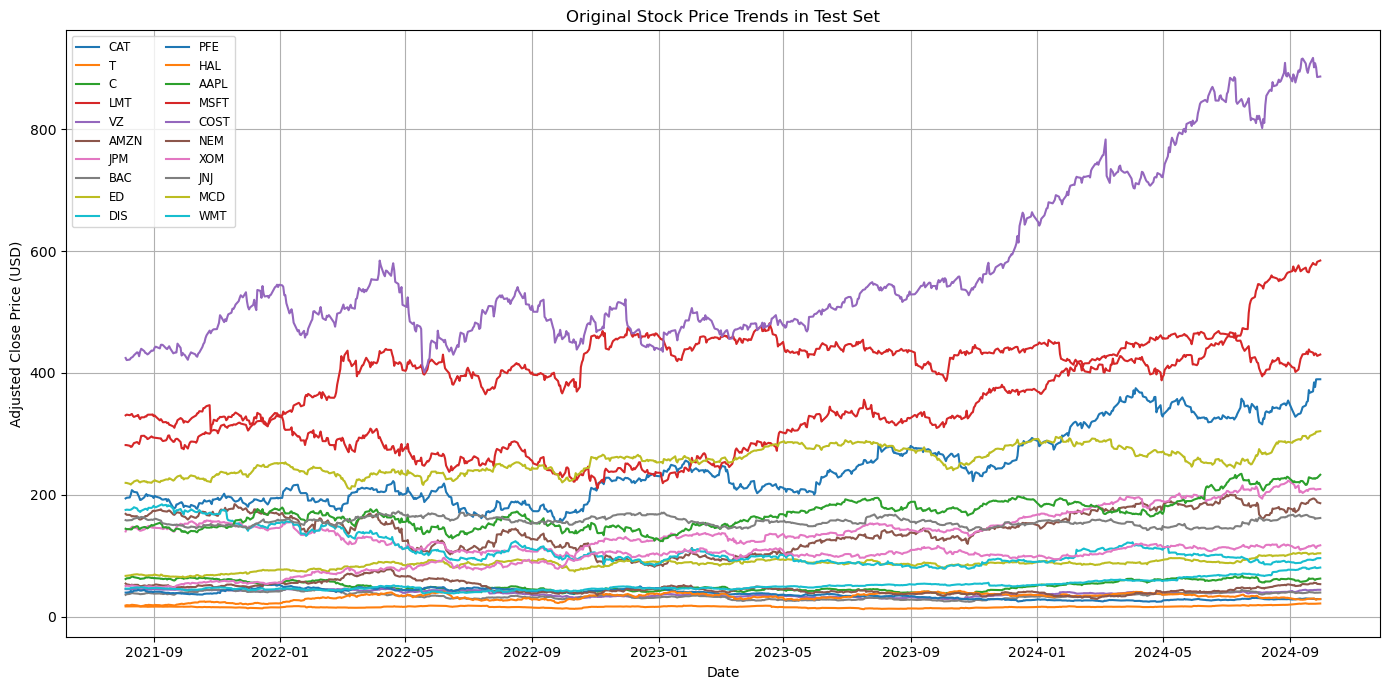

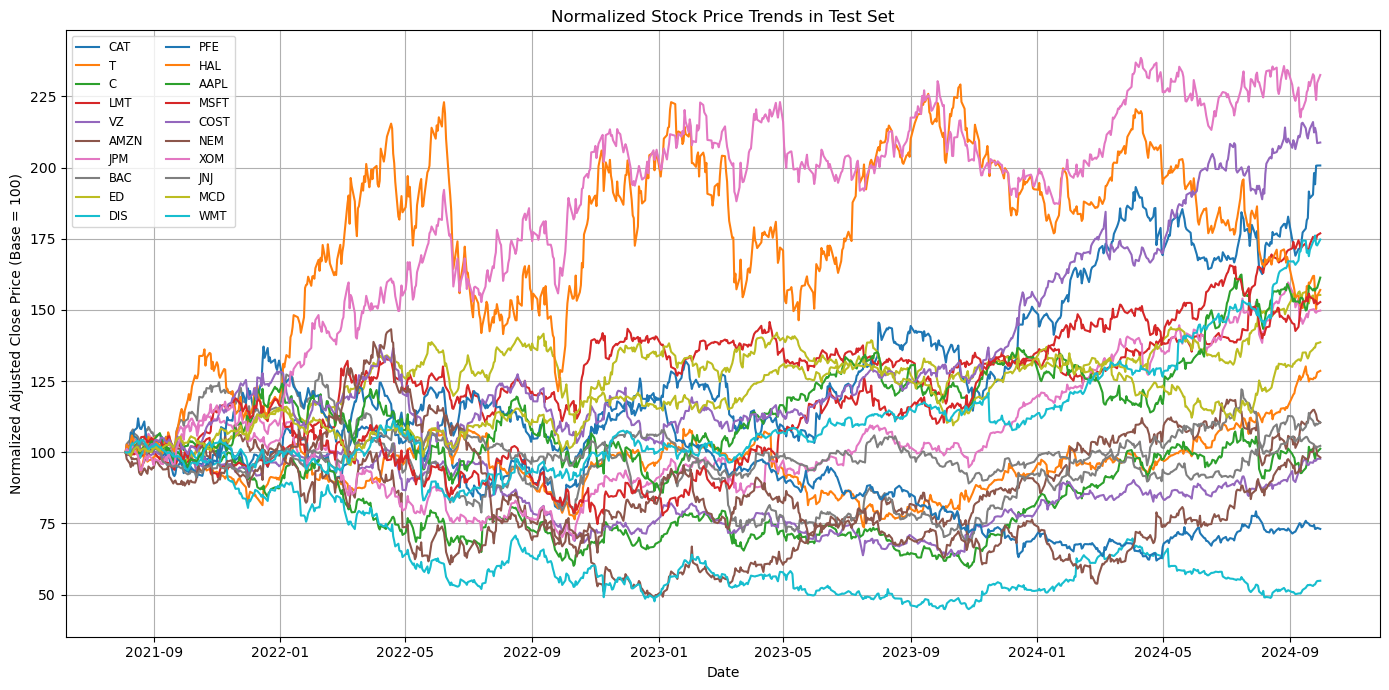

In [5]:
import os
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt


# Define the TrainTest class
class TrainTest:
    def __init__(
        self,
        data: pd.DataFrame,
        number_of_observation_per_window: int,
        split_ratio_list: list[float],
    ) -> None:
        self.data: pd.DataFrame = data
        self.number_of_observation_per_window: int = number_of_observation_per_window
        self.split_ratio: list[float] = split_ratio_list

        num_total_observations: int = self.data.shape[0]
        num_observations_cumulative_split: list[float] = (
            num_total_observations * np.cumsum(split_ratio_list)
        )
        self.cumulative_number_window_observation: list[int] = [
            round(num_observation_cumulative_split)
            for num_observation_cumulative_split in num_observations_cumulative_split
        ]

    def split_update(self, split_ratio_list: list[float]) -> None:
        self.split_ratio: list[float] = split_ratio_list
        num_observations_total: int = self.data.shape[0]
        num_observations_cumulative_split: list[float] = (
            num_observations_total * np.cumsum(split_ratio_list)
        )
        self.cumulative_number_window_observation = [
            round(i) for i in num_observations_cumulative_split
        ]

    def train(self) -> pd.DataFrame:
        return self.data[: self.cumulative_number_window_observation[0]]

    def test(self) -> pd.DataFrame:
        if (
            self.cumulative_number_window_observation[0]
            - self.number_of_observation_per_window
            < 0
        ):
            raise ValueError(
                "The number of observations per window exceeds the number of observations of train data in the dataset."
            )
        return self.data[
            self.cumulative_number_window_observation[0]
            - self.number_of_observation_per_window : self.cumulative_number_window_observation[
                1
            ]
        ]

    def shape(self):
        return self.data.shape


def AV_yFinance(
    start: str,
    end: str,
    split: list[float],
    freq: str = "weekly",
    n_obs: int = 104,
    n_y: int | None = None,
    use_cache: bool = False,
    save_results: bool = False,
) -> tuple[TrainTest, TrainTest, pd.DataFrame]:
    """
    Fetches and processes asset and factor data.

    Returns:
        X_train_test (TrainTest): Training and testing sets for factors.
        Y_train_test (TrainTest): Training and testing sets for asset returns.
        adj_close (pd.DataFrame): Adjusted close prices for all assets.
    """

    if use_cache:
        X = pd.read_pickle(f"./cache/factor_{freq}.pkl")
        Y = pd.read_pickle(f"./cache/asset_{freq}.pkl")
    else:
        # Define the list of tickers
        tick_list = [
            "AAPL",
            "MSFT",
            "AMZN",
            "C",
            "JPM",
            "BAC",
            "XOM",
            "HAL",
            "MCD",
            "WMT",
            "COST",
            "CAT",
            "LMT",
            "JNJ",
            "PFE",
            "DIS",
            "VZ",
            "T",
            "ED",
            "NEM",
        ]

        if n_y is not None:
            tick_list = tick_list[:n_y]

        # Download asset data using yfinance
        data = yf.download(
            tick_list,
            start=start,
            end=end,
            progress=False,
            group_by="ticker",
            auto_adjust=True,  # Adjusted close prices
            threads=True,  # Enable multi-threading for faster downloads
        )

        if data.empty:
            raise ValueError(
                "No data downloaded. Please check the ticker symbols and date range."
            )

        # Extract Adjusted Close prices
        if len(tick_list) == 1:
            # For single ticker, data['Close'] is a Series, convert to DataFrame
            adj_close = data["Close"].to_frame()
            adj_close.columns = tick_list
        else:
            # For multiple tickers, use xs to extract 'Close' for all tickers
            try:
                adj_close = data.xs("Close", level=1, axis=1)
            except KeyError:
                raise KeyError("Close prices not found in the downloaded data.")

        # Compute daily returns as percentage change
        Y = adj_close.pct_change().dropna()

        # Download factor data from Kenneth French's data library
        dl_freq = "_daily"

        try:
            # 5-Factor Model
            factor_5 = pdr.get_data_famafrench(
                "F-F_Research_Data_5_Factors_2x3" + dl_freq,
                start=start,
                end=end,
            )[0]
            rf_df = factor_5["RF"]
            factor_5 = factor_5.drop(["RF"], axis=1)

            # Momentum Factor
            mom_df = pdr.get_data_famafrench(
                "F-F_Momentum_Factor" + dl_freq,
                start=start,
                end=end,
            )[0]

            # Short-Term Reversal Factor
            st_df = pdr.get_data_famafrench(
                "F-F_ST_Reversal_Factor" + dl_freq,
                start=start,
                end=end,
            )[0]

            # Long-Term Reversal Factor
            lt_df = pdr.get_data_famafrench(
                "F-F_LT_Reversal_Factor" + dl_freq,
                start=start,
                end=end,
            )[0]

            # Concatenate all factors and convert to decimal
            X = pd.concat([factor_5, mom_df, st_df, lt_df], axis=1) / 100
        except Exception as e:
            raise ValueError(f"Failed to download factor data: {e}")

        # Align factor data (X) with asset returns (Y) based on dates

        # Remove timezone from Y.index if present
        if Y.index.tz is not None:
            Y.index = Y.index.tz_convert(None)

        # Ensure X.index is also timezone-naive
        if X.index.tz is not None:
            X.index = X.index.tz_convert(None)

        # Now, perform the alignment
        try:
            X = X.loc[Y.index]
        except KeyError as e:
            missing_dates = Y.index.difference(X.index)
            if not missing_dates.empty:
                print(f"Missing dates in factor data: {missing_dates}")
                # Optionally, you can drop missing dates or handle them differently
                Y = Y.loc[Y.index.intersection(X.index)]
                X = X.loc[X.index.intersection(Y.index)]
            else:
                raise e  # Re-raise if no missing dates found

        # Resample data if frequency is not daily
        freq_lower = freq.lower()
        if freq_lower in ["weekly", "wk", "1wk"]:
            Y = Y.resample("W-FRI").apply(lambda x: (x + 1).prod() - 1)
            X = X.resample("W-FRI").apply(lambda x: (x + 1).prod() - 1)
            adj_close = adj_close.resample("W-FRI").last()
        elif freq_lower in ["monthly", "1mo"]:
            Y = Y.resample("M").apply(lambda x: (x + 1).prod() - 1)
            X = X.resample("M").apply(lambda x: (x + 1).prod() - 1)
            adj_close = adj_close.resample("M").last()
        # Add more resampling frequencies if needed

        # Handle missing values by forward and backward filling using ffill() and bfill()
        Y = Y.ffill().bfill()
        X = X.ffill().bfill()
        adj_close = adj_close.ffill().bfill()

        # Convert the index to 'YYYY-MM-DD' format
        X.index = pd.to_datetime(X.index.strftime("%Y-%m-%d"))
        Y.index = pd.to_datetime(Y.index.strftime("%Y-%m-%d"))
        adj_close.index = pd.to_datetime(adj_close.index.strftime("%Y-%m-%d"))

        # Optionally save the results to cache
        if save_results:
            os.makedirs("./cache", exist_ok=True)
            X.to_pickle(f"./cache/factor_{freq}.pkl")
            Y.to_pickle(f"./cache/asset_{freq}.pkl")

    print(f"Factor Data Shape: {X.shape}, Asset Data Shape: {Y.shape}")

    # Partition dataset into training and testing sets. Lag the data by one observation
    X_train_test = TrainTest(X[:-1], n_obs, split)
    Y_train_test = TrainTest(Y[1:], n_obs, split)

    return X_train_test, Y_train_test, adj_close


# Parameters
start_paddling = "1997-04-01"
end_paddling = "2024-10-01"  # Data frequency and start/end dates
daily_frequency = "daily"

# Call the AV_yFinance function
xf_train_test, yf_train_test, adj_close = AV_yFinance(
    start=start_paddling,
    end=end_paddling,
    split=[0.9, 0.1],
    freq=daily_frequency,
    n_obs=104,
    n_y=20,
    use_cache=False,
    save_results=True,
)

# Print shapes of the train and test sets
print(
    "X Train Shape:",
    xf_train_test.train().shape,
    "\nY Train Shape:",
    yf_train_test.train().shape,
    "\nX Test Shape:",
    xf_train_test.test().shape,
    "\nY Test Shape:",
    yf_train_test.test().shape,
)

# Display head and tail of training and testing sets
print("\nX Train Head:\n", xf_train_test.train().head())
print("\nX Test Tail:\n", xf_train_test.test().tail())
print("\nY Train Head:\n", yf_train_test.train().head())
print("\nY Test Tail:\n", yf_train_test.test().tail())

# --- Visualization of the Test Set ---

# Step 1: Extract test set indices
test_indices = yf_train_test.test().index

# Step 2: Extract adjusted close prices for the test set
adj_close_test = adj_close.loc[test_indices]

# Step 3: Plotting

# ---- Option A: Plot Original Adjusted Close Prices ----
plt.figure(figsize=(14, 7))
for ticker in adj_close_test.columns:
    plt.plot(adj_close_test.index, adj_close_test[ticker], label=ticker)

plt.title("Original Stock Price Trends in Test Set")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price (USD)")
plt.legend(loc="upper left", ncol=2, fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Option B: Plot Normalized Adjusted Close Prices ----
# Normalize the adjusted close prices in the test set
normalized_prices_test = adj_close_test / adj_close_test.iloc[0] * 100

plt.figure(figsize=(14, 7))
for ticker in normalized_prices_test.columns:
    plt.plot(normalized_prices_test.index, normalized_prices_test[ticker], label=ticker)

plt.title("Normalized Stock Price Trends in Test Set")
plt.xlabel("Date")
plt.ylabel("Normalized Adjusted Close Price (Base = 100)")
plt.legend(loc="upper left", ncol=2, fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.show()

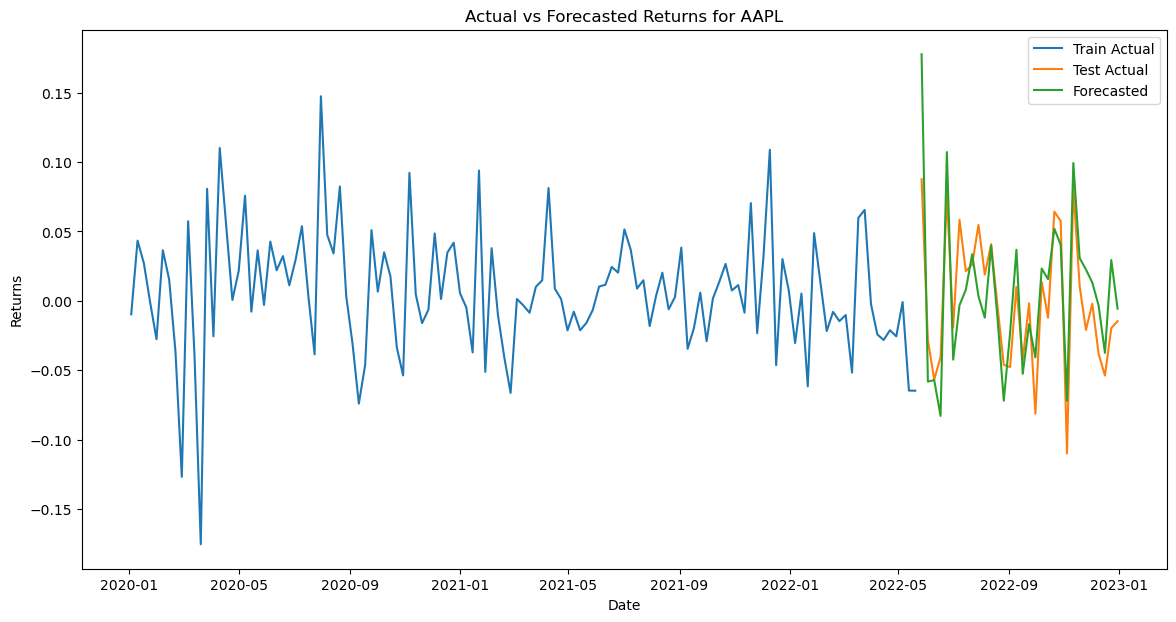

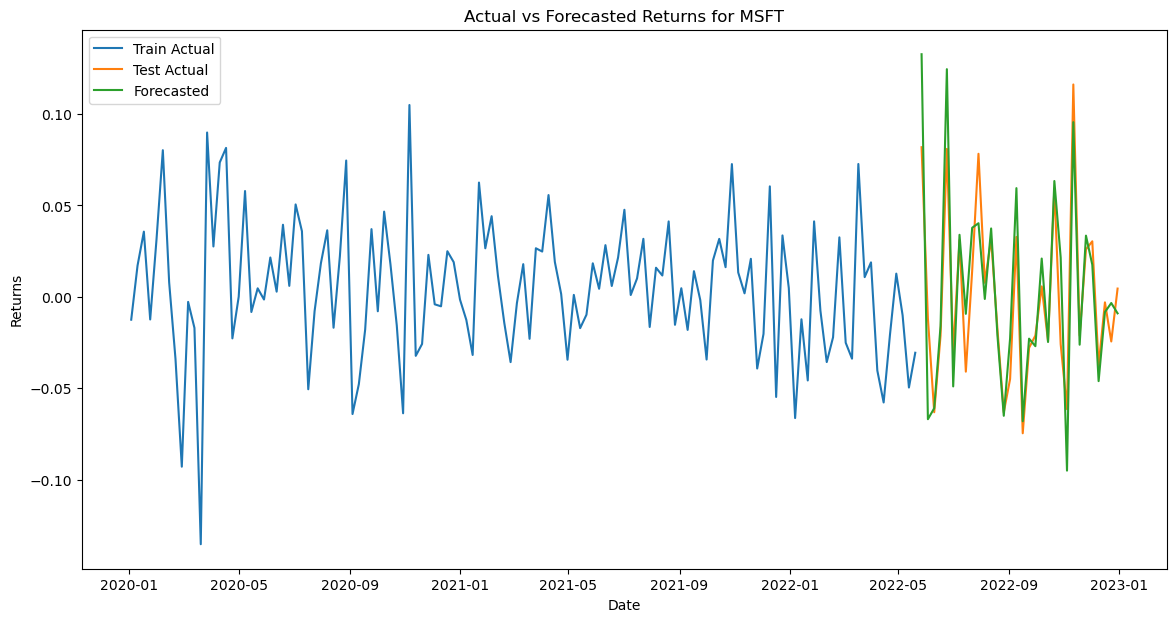

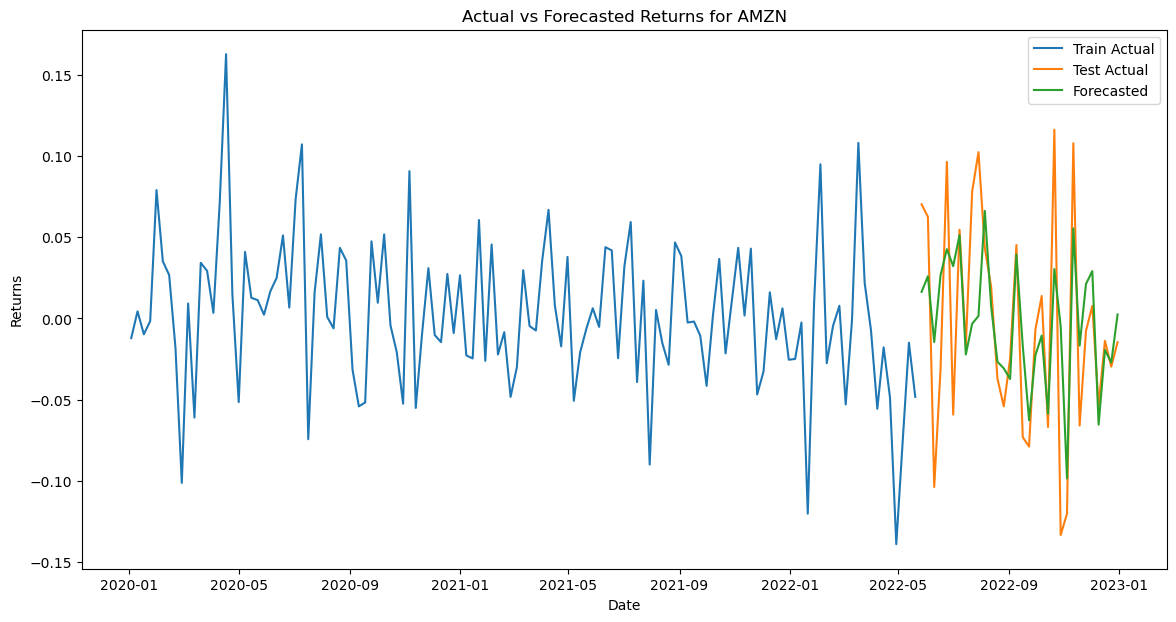

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from typing import Tuple
import warnings
import yfinance as yf
import pandas_datareader.data as pdr

warnings.filterwarnings("ignore")


def prepare_data(X: pd.DataFrame, Y: pd.DataFrame) -> pd.DataFrame:
    """
    Aligns and merges the factor data (X) and asset returns (Y) on their indices.

    Parameters:
    - X (pd.DataFrame): DataFrame of exogenous variables (factors).
    - Y (pd.DataFrame): DataFrame of endogenous variables (asset returns).

    Returns:
    - pd.DataFrame: Combined DataFrame with aligned Y and X.
    """
    # Ensure both indices are timezone-naive
    X.index = X.index.tz_localize(None)
    Y.index = Y.index.tz_localize(None)

    # Merge X and Y on the index and drop any rows with missing values
    data = pd.concat([Y, X], axis=1).dropna()
    return data


def split_data(
    data: pd.DataFrame, train_size: float = 0.8
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits the data into training and testing sets.

    Parameters:
    - data (pd.DataFrame): The combined DataFrame of Y and X.
    - train_size (float): Proportion of the data to include in the training set.

    Returns:
    - Tuple[pd.DataFrame, pd.DataFrame]: The training and testing DataFrames.
    """
    n_train = int(len(data) * train_size)
    train_data = data.iloc[:n_train]
    test_data = data.iloc[n_train:]
    return train_data, test_data


def rolling_forecast(
    train_data: pd.DataFrame, test_data: pd.DataFrame, exog_vars: list
) -> pd.DataFrame:
    """
    Performs rolling forecast using VARMAX model, updating the model at each step.

    Parameters:
    - train_data (pd.DataFrame): Training data containing both Y and X.
    - test_data (pd.DataFrame): Testing data containing both Y and X.
    - exog_vars (list): List of column names for exogenous variables.

    Returns:
    - pd.DataFrame: DataFrame containing the forecasted values.
    """
    # Initialize the list to store forecasts
    forecasts = []
    index = []

    # Combine train and test data for indexing
    combined_data = pd.concat([train_data, test_data])

    # Endogenous variables (Y)
    endog_vars = [col for col in train_data.columns if col not in exog_vars]

    # Initial training data
    history = train_data.copy()

    for t in range(len(test_data)):
        # Extract exogenous variables for current step
        exog_train = history[exog_vars]
        endog_train = history[endog_vars]

        # Fit the VARMAX model
        model = VARMAX(endog_train, exog=exog_train, order=(1, 0))
        model_fit = model.fit(disp=False)

        # Get exogenous variables for forecasting
        exog_forecast = test_data[exog_vars].iloc[t : t + 1]

        # Forecast next time step
        forecast = model_fit.forecast(steps=1, exog=exog_forecast)
        forecasts.append(forecast.iloc[0])
        index.append(test_data.index[t])

        # Append the actual observed data to history
        new_row = pd.DataFrame(test_data.iloc[t : t + 1])
        history = pd.concat([history, new_row])

    # Convert forecasts to DataFrame
    forecast_df = pd.DataFrame(forecasts, index=index)
    return forecast_df


def plot_forecasts(
    train_data: pd.DataFrame,
    test_data: pd.DataFrame,
    forecast: pd.DataFrame,
    asset: str,
):
    """
    Plots the actual and forecasted values for a given asset.

    Parameters:
    - train_data (pd.DataFrame): Training data containing actual values.
    - test_data (pd.DataFrame): Testing data containing actual values.
    - forecast (pd.DataFrame): Forecasted values.
    - asset (str): Name of the asset to plot.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(train_data.index, train_data[asset], label="Train Actual")
    plt.plot(test_data.index, test_data[asset], label="Test Actual")
    plt.plot(forecast.index, forecast[asset], label="Forecasted")
    plt.title(f"Actual vs Forecasted Returns for {asset}")
    plt.xlabel("Date")
    plt.ylabel("Returns")
    plt.legend()
    plt.show()


# Main execution
if __name__ == "__main__":
    # Suppress SettingWithCopyWarning
    pd.options.mode.chained_assignment = None

    # Define date range
    start_date = "2020-01-01"
    end_date = "2022-12-31"

    # Define tickers
    tick_list = [
        "AAPL",
        "MSFT",
        "AMZN",
        "C",
        "JPM",
        "BAC",
        "XOM",
        "HAL",
        "MCD",
        "WMT",
        "COST",
        "CAT",
        "LMT",
        "JNJ",
        "PFE",
        "DIS",
        "VZ",
        "T",
        "ED",
        "NEM",
    ]

    # Download asset data using yfinance
    data = yf.download(
        tick_list,
        start=start_date,
        end=end_date,
        progress=False,
        group_by="ticker",
        auto_adjust=True,
        threads=True,
    )

    # Extract Close prices
    if len(tick_list) == 1:
        adj_close = data["Close"].to_frame()
        adj_close.columns = tick_list
    else:
        adj_close = data.xs("Close", level=1, axis=1)

    # Compute daily returns
    Y = adj_close.pct_change().dropna()

    # Download factor data
    factor_5 = pdr.get_data_famafrench(
        "F-F_Research_Data_5_Factors_2x3_daily",
        start=start_date,
        end=end_date,
    )[0]
    rf_df = factor_5["RF"]
    factor_5 = factor_5.drop(["RF"], axis=1)

    # Momentum Factor
    mom_df = pdr.get_data_famafrench(
        "F-F_Momentum_Factor_daily",
        start=start_date,
        end=end_date,
    )[0]

    # Short-Term Reversal Factor
    st_df = pdr.get_data_famafrench(
        "F-F_ST_Reversal_Factor_daily",
        start=start_date,
        end=end_date,
    )[0]

    # Long-Term Reversal Factor
    lt_df = pdr.get_data_famafrench(
        "F-F_LT_Reversal_Factor_daily",
        start=start_date,
        end=end_date,
    )[0]

    # Concatenate all factors and convert to decimal
    X = pd.concat([factor_5, mom_df, st_df, lt_df], axis=1) / 100

    # Align dates
    X.index = pd.to_datetime(X.index)
    Y.index = pd.to_datetime(Y.index)

    # Prepare data (handle timezone differences)
    data = prepare_data(X, Y)

    # Resample to weekly frequency
    data = data.resample("W-FRI").apply(lambda x: (x + 1).prod() - 1)

    # Handle missing values
    data = data.ffill().bfill()

    # Split data into training and testing sets
    train_data, test_data = split_data(data, train_size=0.8)

    # Exogenous variables (X)
    exog_vars = X.columns.tolist()

    # Perform rolling forecast
    forecast = rolling_forecast(train_data, test_data, exog_vars)

    # Plot results for a few assets
    assets_to_plot = ["AAPL", "MSFT", "AMZN"]
    for asset in assets_to_plot:
        plot_forecasts(train_data, test_data, forecast, asset)

Y shape: (5946, 10)
Y head:
 Ticker          MSFT         C       JPM       XOM      AAPL       HAL  \
Date                                                                     
1997-05-16 -0.014407 -0.013393 -0.036036 -0.012739 -0.028167 -0.008238   
1997-05-19 -0.002707  0.009049 -0.010681  0.017204 -0.014492 -0.009966   
1997-05-20  0.034745  0.033633  0.041835  0.000000  0.014705  0.006711   
1997-05-21  0.010493 -0.030369 -0.034974  0.006343 -0.021738  0.008334   
1997-05-22  0.002077 -0.006711  0.016108 -0.016807 -0.014813  0.001653   

Ticker          AMZN       MCD       BAC       WMT  
Date                                                
1997-05-16 -0.117028 -0.004785 -0.018292 -0.020492  
1997-05-19 -0.012040  0.002404 -0.016564  0.020920  
1997-05-20 -0.042685 -0.016786  0.012631  0.000000  
1997-05-21 -0.127392 -0.007318 -0.027026 -0.016394  
1997-05-22 -0.021891  0.000000  0.000000 -0.008333  
Y tail:
 Ticker          MSFT         C       JPM       XOM      AAPL       HAL  

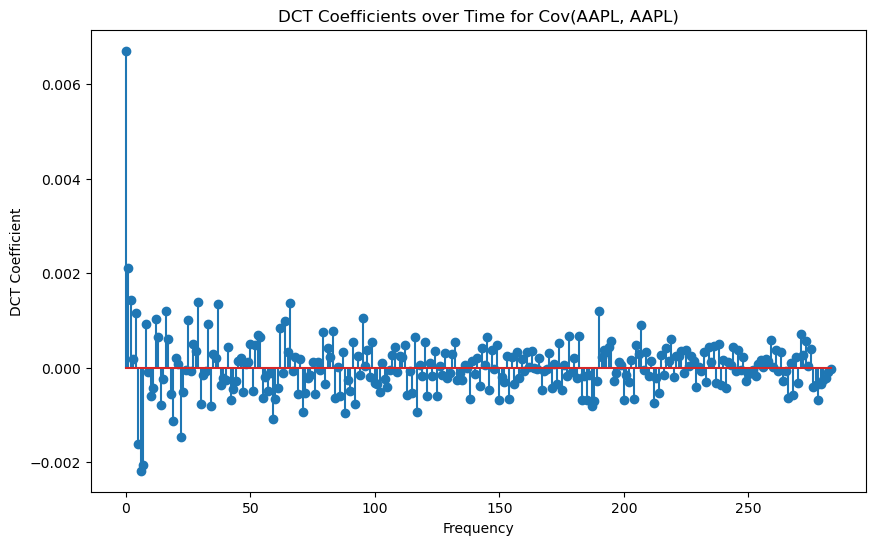

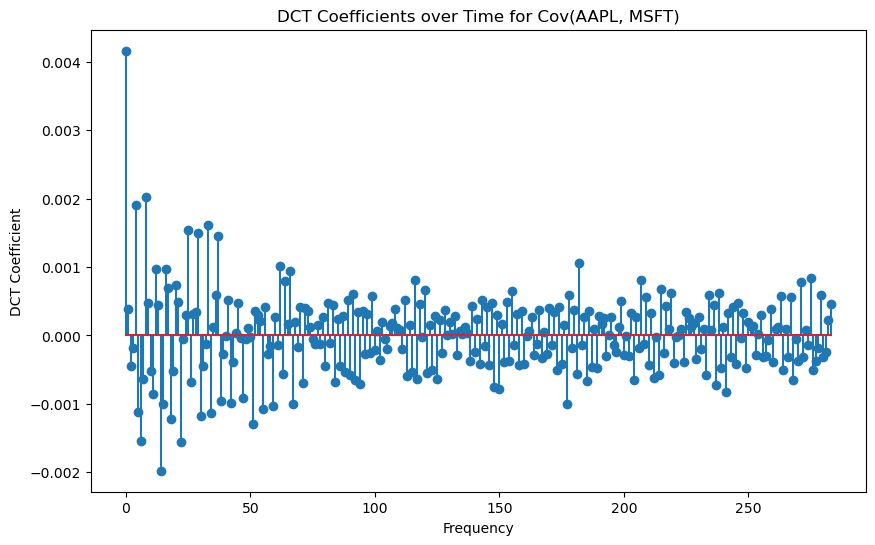

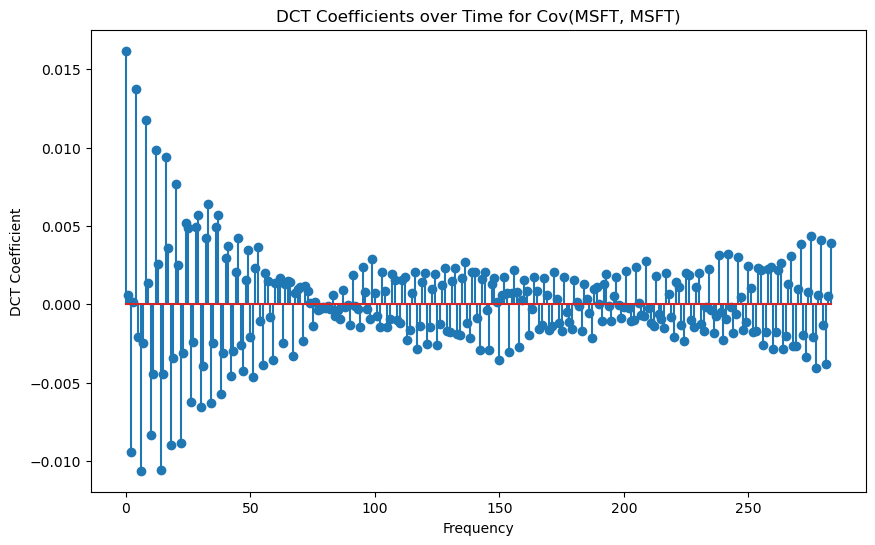

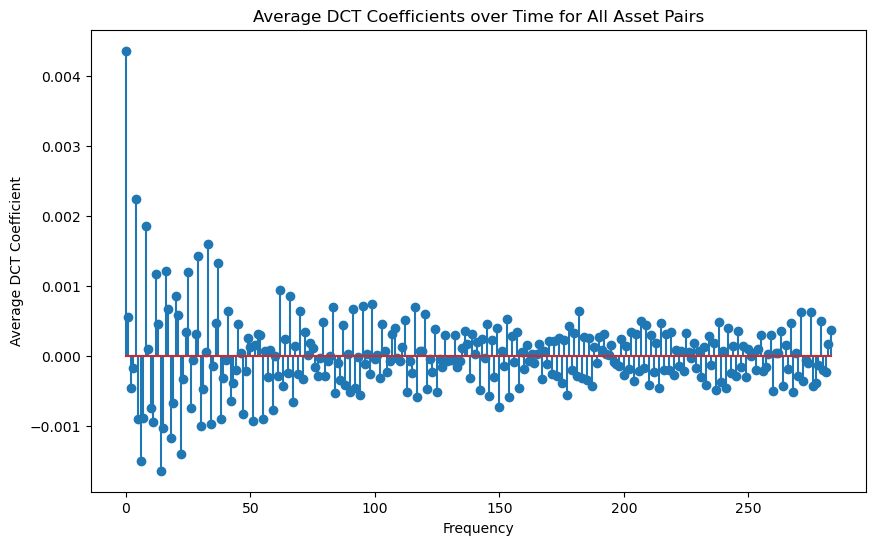

Y shape: (5946, 10)
Covariance matrices shape: (284, 10, 10)


In [ ]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.fftpack import (
    fft,
    fftshift,
    dct,
)  # Import necessary functions for FFT and DCT


def AV_yFinance(
    start: str,
    end: str,
    split: list,
    freq: str = "daily",
    n_obs: int = 104,
    n_y: int = None,
    use_cache: bool = False,
    save_results: bool = False,
):
    if use_cache:
        Y = pd.read_pickle(f"./cache/asset_{freq}.pkl")
    else:
        # Define the list of tickers
        tick_list = [
            "AAPL",
            "MSFT",
            "AMZN",
            "C",
            "JPM",
            "BAC",
            "XOM",
            "HAL",
            "MCD",
            "WMT",
            "COST",
            "CAT",
            "LMT",
            "JNJ",
            "PFE",
            "DIS",
            "VZ",
            "T",
            "ED",
            "NEM",
        ]

        if n_y is not None:
            tick_list = tick_list[:n_y]

        # Download asset data using yfinance
        data = yf.download(
            tick_list,
            start=start,
            end=end,
            progress=False,
            group_by="ticker",
            auto_adjust=True,  # Adjusted close prices
            threads=True,  # Enable multi-threading for faster downloads
        )

        if data.empty:
            raise ValueError(
                "No data downloaded. Please check the ticker symbols and date range."
            )

        # Extract Adjusted Close prices
        if len(tick_list) == 1:
            # For single ticker, data['Close'] is a Series, convert to DataFrame
            adj_close = data["Close"].to_frame()
            adj_close.columns = tick_list
        else:
            # For multiple tickers, use xs to extract 'Close' for all tickers
            try:
                adj_close = data.xs("Close", level=1, axis=1)
            except KeyError:
                raise KeyError("Close prices not found in the downloaded data.")

        # Compute daily returns as percentage change
        Y = adj_close.pct_change().dropna()

        # Remove timezone from Y.index if present
        if Y.index.tz is not None:
            Y.index = Y.index.tz_convert(None)

        # Optionally save the results to cache
        if save_results:
            os.makedirs("./cache", exist_ok=True)
            Y.to_pickle(f"./cache/asset_{freq}.pkl")

    # Print shapes and head/tail of data
    print("Y shape:", Y.shape)
    print("Y head:\n", Y.head())
    print("Y tail:\n", Y.tail())
    print("Above is the original data")

    # Generate covariance matrices for each month
    # We will resample the data monthly and compute the covariance matrix for each month
    covariance_matrices = []
    months = []

    # Resample to monthly periods
    monthly_returns = Y.resample("M")

    for name, group in monthly_returns:
        if len(group) > 1:  # Need at least two data points to compute covariance
            cov_matrix = group.cov()
            covariance_matrices.append(cov_matrix.values)
            months.append(name)

    # Stack covariance matrices into a 3D array (time, assets, assets)
    covariance_matrices = np.array(covariance_matrices)
    print(
        "Covariance matrices shape:", covariance_matrices.shape
    )  # Should be (time, n_assets, n_assets)

    # Now, perform DCT along the time axis for each element in the covariance matrices
    n_assets = covariance_matrices.shape[1]
    dct_results = np.zeros_like(covariance_matrices)

    for i in range(n_assets):
        for j in range(n_assets):
            time_series = covariance_matrices[:, i, j]
            dct_result = dct(time_series, type=2, norm="ortho")
            dct_results[:, i, j] = dct_result

    # Visualize the DCT coefficients for a selected pair of assets
    asset_pairs = [
        (0, 0),
        (0, 1),
        (1, 1),
    ]  # Example pairs (AAPL-AAPL, AAPL-MSFT, MSFT-MSFT)
    for i, j in asset_pairs:
        plt.figure(figsize=(10, 6))
        plt.stem(dct_results[:, i, j])  # Removed 'use_line_collection=True'
        plt.title(f"DCT Coefficients over Time for Cov({tick_list[i]}, {tick_list[j]})")
        plt.xlabel("Frequency")
        plt.ylabel("DCT Coefficient")
        plt.show()

    # Alternatively, analyze the average DCT coefficients across all asset pairs
    average_dct = np.mean(dct_results, axis=(1, 2))
    plt.figure(figsize=(10, 6))
    plt.stem(average_dct)  # Removed 'use_line_collection=True'
    plt.title("Average DCT Coefficients over Time for All Asset Pairs")
    plt.xlabel("Frequency")
    plt.ylabel("Average DCT Coefficient")
    plt.show()

    # Return the data if needed
    return Y, covariance_matrices, dct_results


if __name__ == "__main__":
    start_paddling = "1990-01-01"
    end_paddling = "2020-12-31"  # 10 years of data
    daily_frequency = "daily"

    Y, covariance_matrices, dct_results = AV_yFinance(
        start=start_paddling,
        end=end_paddling,
        split=[0.9, 0.1],
        freq=daily_frequency,
        n_obs=104,
        n_y=10,  # Limit to 10 assets to simplify computations
        use_cache=False,
        save_results=False,
    )

    print("Y shape:", Y.shape)
    print("Covariance matrices shape:", covariance_matrices.shape)